# Generic Time Series Modeling

This notebook applies classical time series forecasting methods to predict stock volatility for AAPL and NVDA. We compare three fundamental approaches:

1. **Data Loading & Preparation** - Load volatility data and perform train/test split
2. **Stationarity Analysis** - Test data properties using ADF tests and ACF/PACF plots  
3. **ARIMA Modeling** - Fit autoregressive integrated moving average models with parameter optimization
4. **Exponential Smoothing** - Apply Holt-Winters and related exponential smoothing techniques
5. **Prophet Models** - Use Facebook's Prophet for trend and seasonality decomposition
6. **Model Comparison** - Evaluate performance using MAE, RMSE, MAPE, and R² metrics

The goal is to identify the most effective traditional forecasting method for volatility prediction, providing a baseline for comparison with more advanced techniques.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Importing plotly failed. Interactive plots will not work.


Libraries imported successfully!


## 1. Data Loading and Preparation

In [4]:
# Load volatility data
vol_df = pd.read_csv('data/processed/volatility_21d_annualized.csv', parse_dates=['Date'], index_col='Date')

# Select AAPL and NVDA
stocks = ['AAPL', 'NVDA']
vol_data = vol_df[stocks].dropna()

print(f"Data shape: {vol_data.shape}")
print(f"Date range: {vol_data.index.min()} to {vol_data.index.max()}")
print(f"\nSummary Statistics:")
print(vol_data.describe())

Data shape: (2725, 2)
Date range: 2015-02-03 00:00:00 to 2025-12-02 00:00:00

Summary Statistics:
              AAPL         NVDA
count  2725.000000  2725.000000
mean      0.261711     0.447450
std       0.124571     0.191599
min       0.077741     0.139772
25%       0.184124     0.310013
50%       0.236195     0.390086
75%       0.306450     0.552495
max       1.068829     1.393049


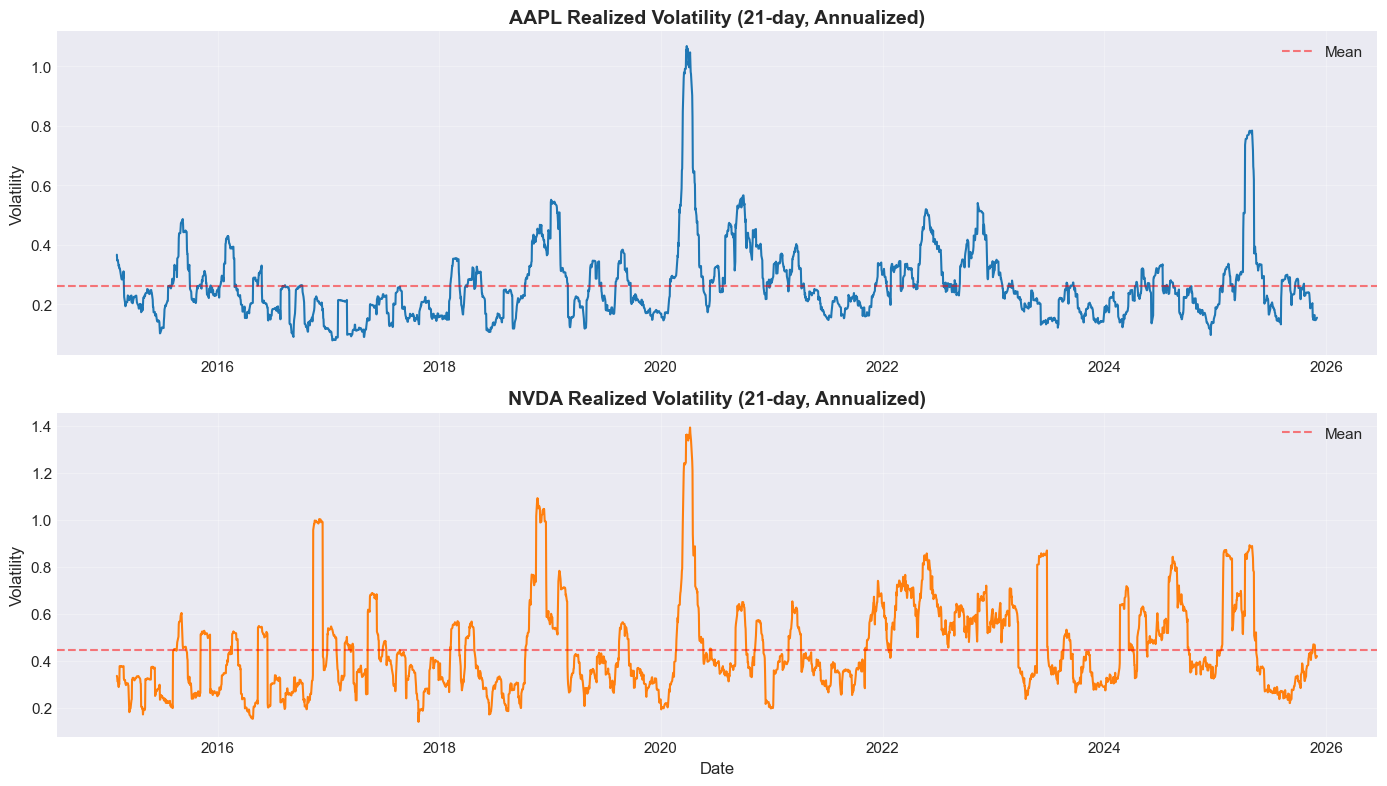

In [5]:
# Visualize the volatility series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for i, stock in enumerate(stocks):
    axes[i].plot(vol_data.index, vol_data[stock], linewidth=1.5, color=['#1f77b4', '#ff7f0e'][i])
    axes[i].set_title(f'{stock} Realized Volatility (21-day, Annualized)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=vol_data[stock].mean(), color='red', linestyle='--', alpha=0.5, label='Mean')
    axes[i].legend()

axes[1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 2. Train-Test Split

We'll use an 80-20 split for training and testing.

In [6]:
# Split data into train and test sets
train_size = int(len(vol_data) * 0.8)
train_data = vol_data.iloc[:train_size]
test_data = vol_data.iloc[train_size:]

print(f"Training set: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} samples)")
print(f"Test set: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} samples)")

Training set: 2015-02-03 00:00:00 to 2023-09-29 00:00:00 (2180 samples)
Test set: 2023-10-02 00:00:00 to 2025-12-02 00:00:00 (545 samples)


## 3. Stationarity Analysis

Before modeling, we need to check if the series are stationary using the Augmented Dickey-Fuller (ADF) test.

In [7]:
def adf_test(series, name):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f'\n{name} ADF Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.4f}')
    
    if result[1] < 0.05:
        print(f"✓ Series is stationary (reject H0 at 5% level)")
    else:
        print(f"✗ Series is non-stationary (fail to reject H0)")
    
    return result[1] < 0.05

# Test stationarity for both stocks
for stock in stocks:
    adf_test(train_data[stock], stock)


AAPL ADF Test Results:
ADF Statistic: -4.9362
p-value: 0.0000
Critical Values:
  1%: -3.4334
  5%: -2.8629
  10%: -2.5675
✓ Series is stationary (reject H0 at 5% level)

NVDA ADF Test Results:
ADF Statistic: -4.8184
p-value: 0.0001
Critical Values:
  1%: -3.4334
  5%: -2.8629
  10%: -2.5675
✓ Series is stationary (reject H0 at 5% level)


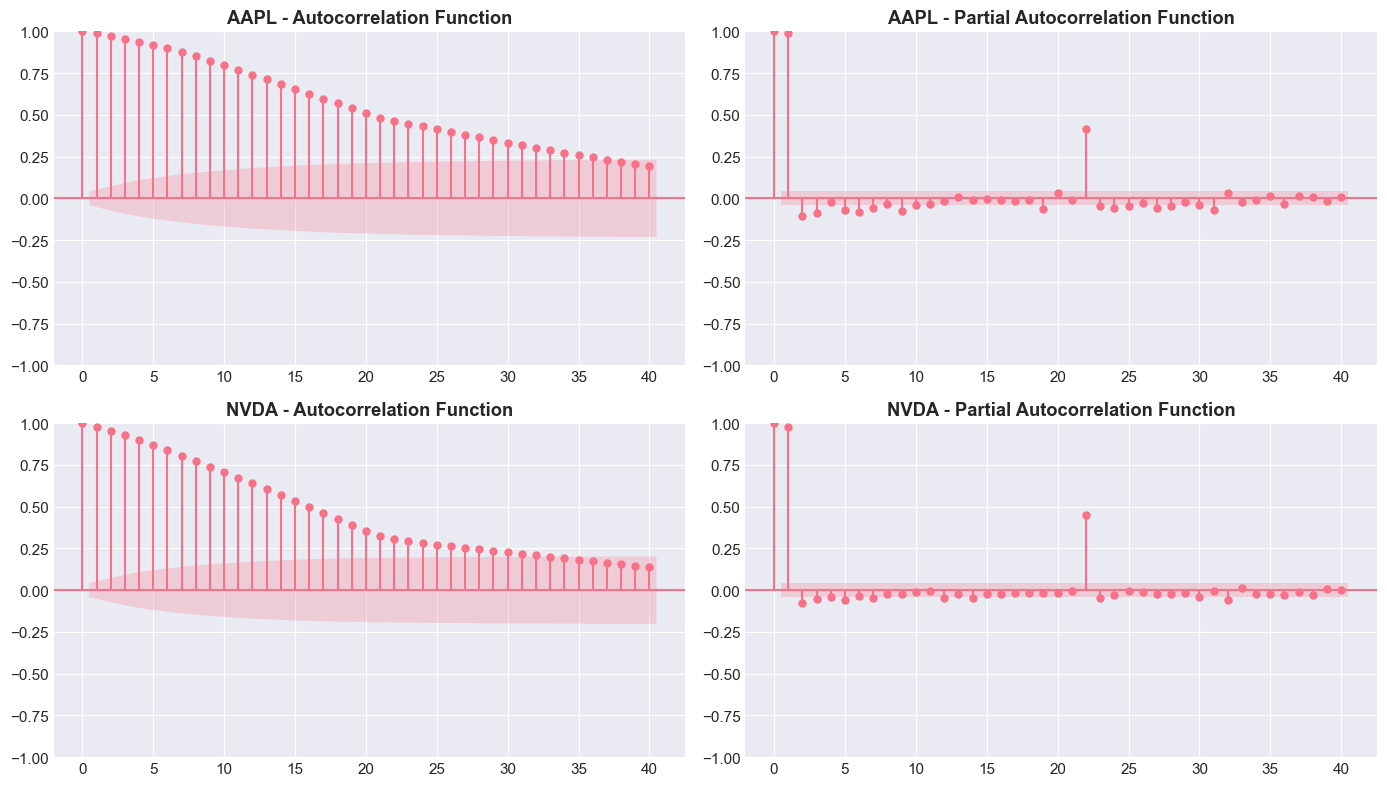

In [8]:
# Plot ACF and PACF for both stocks
fig, axes = plt.subplots(len(stocks), 2, figsize=(14, 8))

for i, stock in enumerate(stocks):
    plot_acf(train_data[stock].dropna(), ax=axes[i, 0], lags=40, alpha=0.05)
    axes[i, 0].set_title(f'{stock} - Autocorrelation Function', fontweight='bold')
    
    plot_pacf(train_data[stock].dropna(), ax=axes[i, 1], lags=40, alpha=0.05)
    axes[i, 1].set_title(f'{stock} - Partial Autocorrelation Function', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. ARIMA Modeling

### 4.1 Model Selection and Fitting

We'll test multiple ARIMA configurations and select the best based on AIC.

In [9]:
def find_best_arima(series, p_range=range(0, 6), d_range=range(0, 3), q_range=range(0, 6)):
    """Grid search for best ARIMA parameters based on AIC"""
    best_aic = np.inf
    best_params = None
    best_model = None
    
    results = []
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted = model.fit()
                    results.append({
                        'order': (p, d, q),
                        'aic': fitted.aic,
                        'bic': fitted.bic,
                        'hqic': fitted.hqic
                    })
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_params = (p, d, q)
                        best_model = fitted
                except:
                    continue
    
    results_df = pd.DataFrame(results).sort_values('aic').head(10)
    return best_model, best_params, results_df

# Find best ARIMA models for both stocks
arima_models = {}
arima_params = {}
arima_results = {}

for stock in stocks:
    print(f"\n{'='*60}")
    print(f"Finding best ARIMA model for {stock}...")
    print(f"{'='*60}")
    
    model, params, results_df = find_best_arima(train_data[stock].dropna())
    arima_models[stock] = model
    arima_params[stock] = params
    arima_results[stock] = results_df
    
    print(f"\nBest ARIMA{params} for {stock}")
    print(f"AIC: {model.aic:.4f}")
    print(f"BIC: {model.bic:.4f}")
    print(f"\nTop 10 models by AIC:")
    print(results_df)


Finding best ARIMA model for AAPL...


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv


Best ARIMA(2, 0, 5) for AAPL
AIC: -11054.2332
BIC: -11003.0495

Top 10 models by AIC:
        order           aic           bic          hqic
41  (2, 0, 5) -11054.233179 -11003.049457 -11035.521440
59  (3, 0, 5) -11049.573219 -10992.702418 -11028.782399
37  (2, 0, 1) -11048.694716 -11020.259315 -11038.299306
77  (4, 0, 5) -11046.864901 -10984.307019 -11023.994998
94  (5, 0, 5) -11039.460717 -10971.215755 -11014.511732
90  (5, 0, 0) -11018.724554 -10978.914993 -11004.170980
23  (1, 0, 5) -11017.931113 -10972.434472 -11001.298457
29  (1, 1, 5) -11015.939627 -10976.133278 -11001.386888
38  (2, 0, 2) -11015.700590 -10981.578109 -11003.226098
47  (2, 1, 5) -11013.853244 -10968.360274 -10997.221543

Finding best ARIMA model for NVDA...


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv


Best ARIMA(5, 0, 5) for NVDA
AIC: -7894.3377
BIC: -7826.0927

Top 10 models by AIC:
        order          aic          bic         hqic
95  (5, 0, 5) -7894.337687 -7826.092725 -7869.388703
75  (4, 0, 3) -7861.745206 -7810.561484 -7843.033467
37  (2, 0, 1) -7861.179335 -7832.743934 -7850.783925
92  (5, 0, 2) -7857.444480 -7806.260758 -7838.732741
40  (2, 0, 4) -7856.668882 -7811.172241 -7840.036226
56  (3, 0, 2) -7856.187626 -7816.378065 -7841.634052
52  (2, 2, 4) -7855.950248 -7816.147112 -7841.398346
41  (2, 0, 5) -7854.454943 -7803.271222 -7835.743205
58  (3, 0, 4) -7854.425829 -7803.242108 -7835.714091
59  (3, 0, 5) -7853.556831 -7796.686030 -7832.766011


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 4.2 ARIMA Model Diagnostics

In [10]:
# Detailed model summary for each stock
for stock in stocks:
    print(f"\n{'='*60}")
    print(f"{stock} ARIMA{arima_params[stock]} Model Summary")
    print(f"{'='*60}")
    print(arima_models[stock].summary())


AAPL ARIMA(2, 0, 5) Model Summary
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2180
Model:                 ARIMA(2, 0, 5)   Log Likelihood                5536.117
Date:                Tue, 02 Dec 2025   AIC                         -11054.233
Time:                        22:18:40   BIC                         -11003.049
Sample:                             0   HQIC                        -11035.521
                               - 2180                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2662      0.021     12.558      0.000       0.225       0.308
ar.L1          1.8952      0.026     73.105      0.000       1.844       1.946
ar.L2         -0.


ARIMA Diagnostics for AAPL


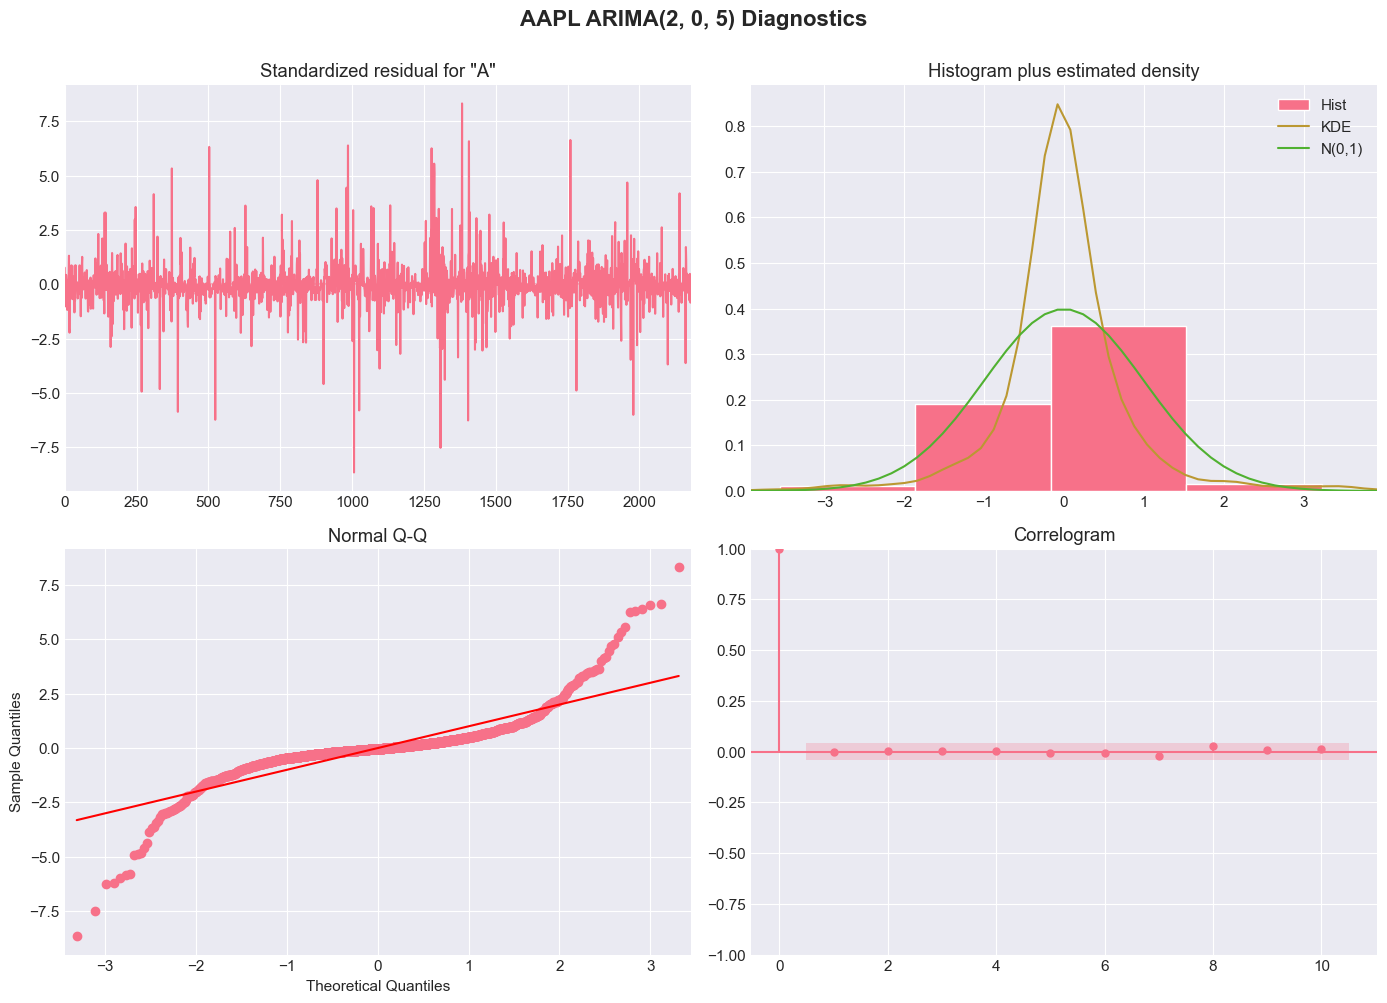


ARIMA Diagnostics for NVDA


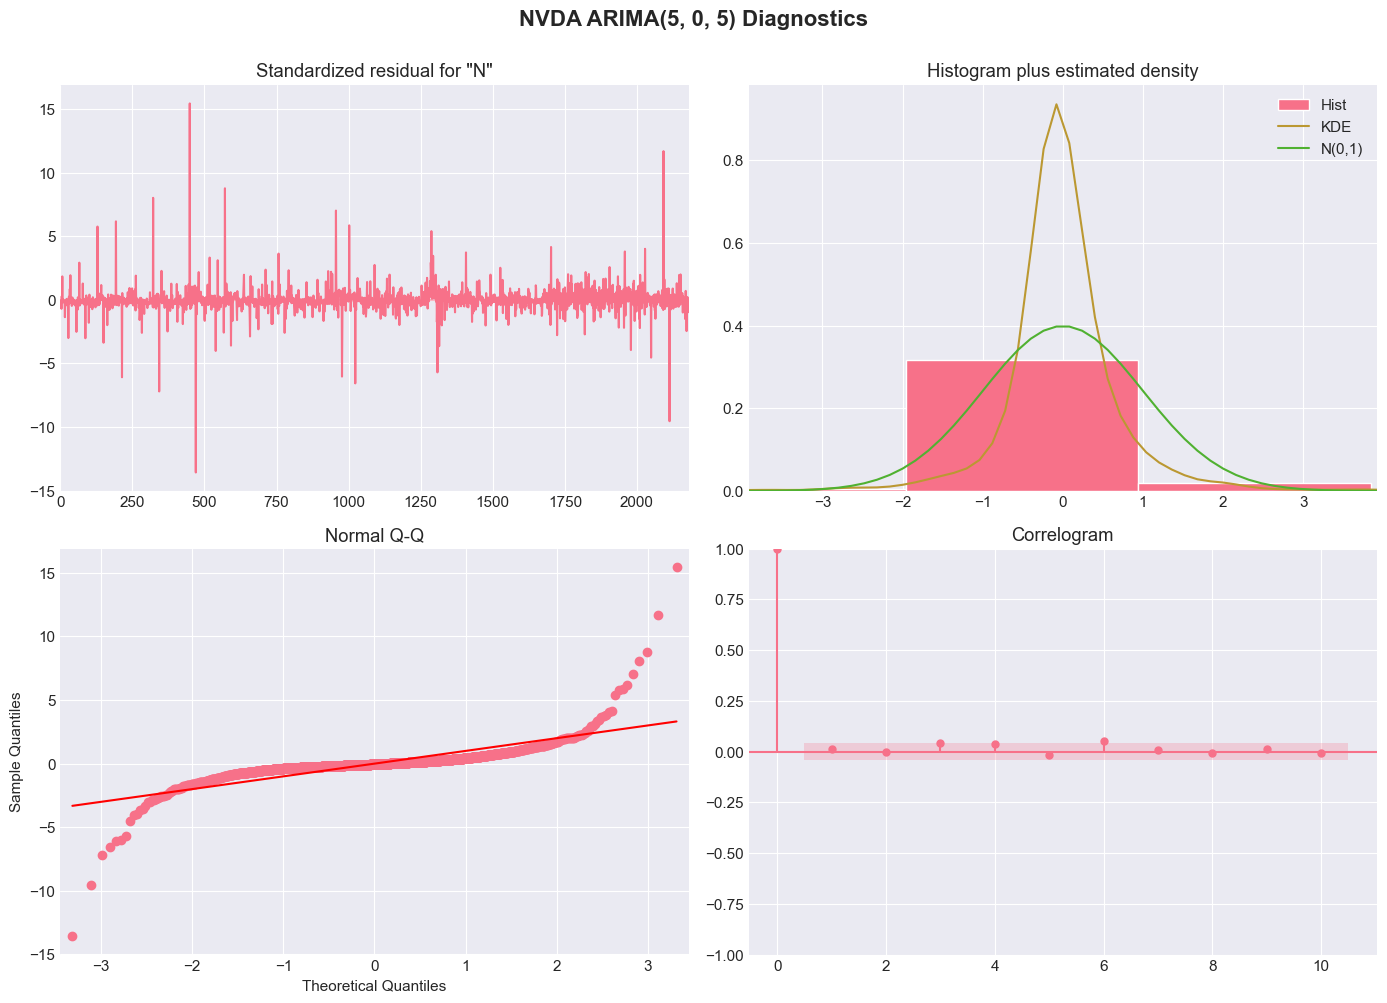

In [11]:
# Plot diagnostics for ARIMA models
for stock in stocks:
    print(f"\nARIMA Diagnostics for {stock}")
    fig = arima_models[stock].plot_diagnostics(figsize=(14, 10))
    fig.suptitle(f'{stock} ARIMA{arima_params[stock]} Diagnostics', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

In [12]:
# Ljung-Box test for residual autocorrelation
for stock in stocks:
    residuals = arima_models[stock].resid
    lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
    
    print(f"\n{stock} - Ljung-Box Test Results:")
    print(lb_test)
    print("\nInterpretation: p-value > 0.05 suggests no significant autocorrelation in residuals (good)")


AAPL - Ljung-Box Test Results:
       lb_stat     lb_pvalue
10    2.738417  9.869276e-01
20   14.388870  8.102448e-01
30  428.943931  3.836676e-72

Interpretation: p-value > 0.05 suggests no significant autocorrelation in residuals (good)

NVDA - Ljung-Box Test Results:
       lb_stat     lb_pvalue
10   15.003421  1.319372e-01
20   24.925286  2.043044e-01
30  444.610238  2.506735e-75

Interpretation: p-value > 0.05 suggests no significant autocorrelation in residuals (good)


### 4.3 ARIMA Forecasting and Evaluation

In [13]:
# Generate forecasts
arima_forecasts = {}
arima_conf_int = {}

for stock in stocks:
    # Forecast
    forecast_result = arima_models[stock].forecast(steps=len(test_data), alpha=0.05)
    arima_forecasts[stock] = forecast_result
    
    # Get prediction intervals
    pred = arima_models[stock].get_prediction(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)
    arima_conf_int[stock] = pred.conf_int(alpha=0.05)

print("ARIMA forecasts generated successfully!")

ARIMA forecasts generated successfully!


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/ba

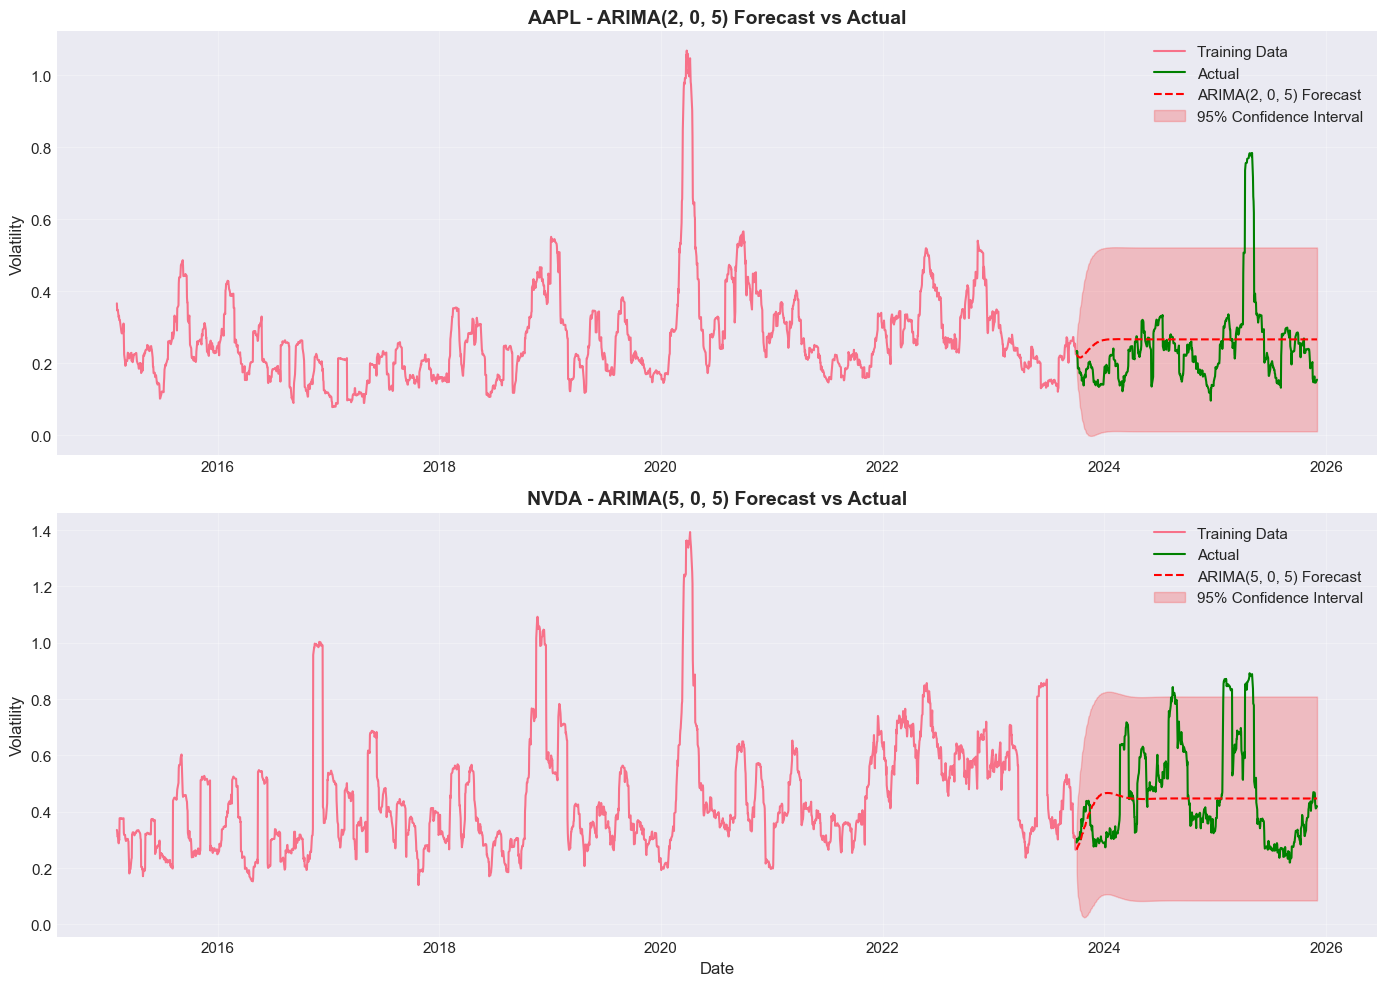

In [14]:
# Plot ARIMA forecasts
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 10))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    axes[i].plot(test_data.index, arima_forecasts[stock], label=f'ARIMA{arima_params[stock]} Forecast', 
                linewidth=1.5, color='red', linestyle='--')
    
    # Plot confidence interval
    axes[i].fill_between(test_data.index, 
                         arima_conf_int[stock].iloc[:, 0], 
                         arima_conf_int[stock].iloc[:, 1],
                         alpha=0.2, color='red', label='95% Confidence Interval')
    
    axes[i].set_title(f'{stock} - ARIMA{arima_params[stock]} Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Calculate ARIMA performance metrics
def calculate_metrics(actual, predicted, model_name):
    """Calculate and display performance metrics"""
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"MAE:  {mae:.6f}")
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²:   {r2:.4f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2}

arima_metrics = {}
for stock in stocks:
    print(f"\n{'='*60}")
    print(f"{stock} - ARIMA{arima_params[stock]}")
    print(f"{'='*60}")
    arima_metrics[stock] = calculate_metrics(test_data[stock], arima_forecasts[stock], 
                                             f"{stock} ARIMA{arima_params[stock]}")


AAPL - ARIMA(2, 0, 5)

AAPL ARIMA(2, 0, 5) Performance Metrics:
MAE:  0.075083
MSE:  0.014042
RMSE: 0.118499
MAPE: nan%
R²:   0.0009

NVDA - ARIMA(5, 0, 5)

NVDA ARIMA(5, 0, 5) Performance Metrics:
MAE:  0.144811
MSE:  0.032577
RMSE: 0.180491
MAPE: nan%
R²:   -0.0057


## 5. Exponential Smoothing Models

### 5.1 Model Fitting

We'll test different exponential smoothing configurations including Simple, Holt, and Holt-Winters.

In [16]:
def fit_exponential_smoothing_models(series, name):
    """Fit multiple exponential smoothing models and compare"""
    models = {}
    aic_scores = {}
    
    # Simple Exponential Smoothing
    try:
        model_ses = ExponentialSmoothing(series, trend=None, seasonal=None)
        fit_ses = model_ses.fit(optimized=True)
        models['SES'] = fit_ses
        aic_scores['SES'] = fit_ses.aic
    except Exception as e:
        print(f"SES failed: {e}")
    
    # Holt's Linear Trend
    try:
        model_holt = ExponentialSmoothing(series, trend='add', seasonal=None)
        fit_holt = model_holt.fit(optimized=True)
        models['Holt'] = fit_holt
        aic_scores['Holt'] = fit_holt.aic
    except Exception as e:
        print(f"Holt failed: {e}")
    
    # Holt-Winters Additive (need sufficient data for seasonal)
    try:
        model_hw_add = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=21)
        fit_hw_add = model_hw_add.fit(optimized=True)
        models['HW_Additive'] = fit_hw_add
        aic_scores['HW_Additive'] = fit_hw_add.aic
    except Exception as e:
        print(f"HW Additive failed: {e}")
    
    # Holt-Winters Multiplicative
    try:
        model_hw_mul = ExponentialSmoothing(series, trend='add', seasonal='mul', seasonal_periods=21)
        fit_hw_mul = model_hw_mul.fit(optimized=True)
        models['HW_Multiplicative'] = fit_hw_mul
        aic_scores['HW_Multiplicative'] = fit_hw_mul.aic
    except Exception as e:
        print(f"HW Multiplicative failed: {e}")
    
    # Find best model
    best_model_name = min(aic_scores, key=aic_scores.get)
    best_model = models[best_model_name]
    
    print(f"\n{name} - Exponential Smoothing Model Comparison:")
    for model_name, aic in sorted(aic_scores.items(), key=lambda x: x[1]):
        print(f"{model_name:20s}: AIC = {aic:.4f}")
    print(f"\nBest model: {best_model_name}")
    
    return models, best_model_name, best_model

# Fit models for both stocks
es_models = {}
es_best_names = {}
es_best_models = {}

for stock in stocks:
    print(f"\n{'='*60}")
    print(f"Fitting Exponential Smoothing models for {stock}")
    print(f"{'='*60}")
    models, best_name, best_model = fit_exponential_smoothing_models(train_data[stock].dropna(), stock)
    es_models[stock] = models
    es_best_names[stock] = best_name
    es_best_models[stock] = best_model


Fitting Exponential Smoothing models for AAPL


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv


AAPL - Exponential Smoothing Model Comparison:
SES                 : AIC = -17149.5368
Holt                : AIC = -17126.2146
HW_Multiplicative   : AIC = -17088.0249
HW_Additive         : AIC = -17086.0081

Best model: SES

Fitting Exponential Smoothing models for NVDA


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv


NVDA - Exponential Smoothing Model Comparison:
SES                 : AIC = -13992.0072
Holt                : AIC = -13988.0086
HW_Multiplicative   : AIC = -13950.2348
HW_Additive         : AIC = -13946.7534

Best model: SES


In [17]:
# Display model summaries
for stock in stocks:
    print(f"\n{'='*60}")
    print(f"{stock} - {es_best_names[stock]} Model Summary")
    print(f"{'='*60}")
    print(es_best_models[stock].summary())


AAPL - SES Model Summary
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     AAPL   No. Observations:                 2180
Model:             ExponentialSmoothing   SSE                              0.834
Optimized:                         True   AIC                         -17149.537
Trend:                             None   BIC                         -17138.163
Seasonal:                          None   AICC                        -17149.518
Seasonal Periods:                  None   Date:                 Tue, 02 Dec 2025
Box-Cox:                          False   Time:                         22:18:42
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_

### 5.2 Exponential Smoothing Forecasting and Evaluation

In [18]:
# Generate forecasts
es_forecasts = {}

for stock in stocks:
    es_forecasts[stock] = es_best_models[stock].forecast(steps=len(test_data))

print("Exponential Smoothing forecasts generated successfully!")

Exponential Smoothing forecasts generated successfully!


/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/oorjitchowdhary/Documents/UW/Fall 2025/ECE 344/coursework/.venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


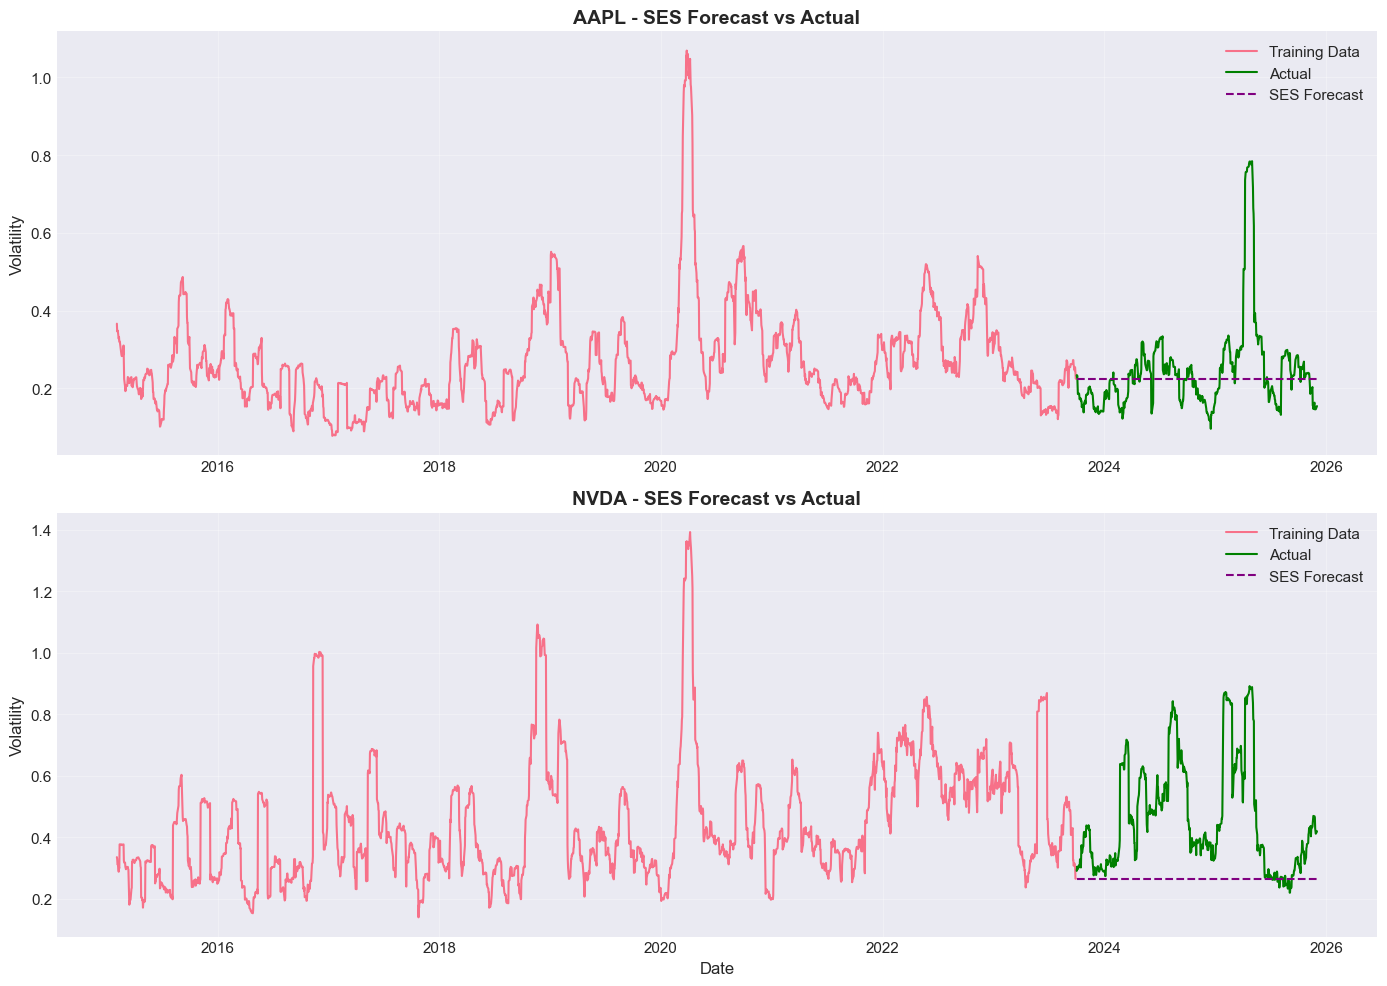

In [19]:
# Plot forecasts
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 10))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    axes[i].plot(test_data.index, es_forecasts[stock], label=f'{es_best_names[stock]} Forecast', 
                linewidth=1.5, color='purple', linestyle='--')
    
    axes[i].set_title(f'{stock} - {es_best_names[stock]} Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# Calculate performance metrics
es_metrics = {}
for stock in stocks:
    print(f"\n{'='*60}")
    print(f"{stock} - {es_best_names[stock]}")
    print(f"{'='*60}")
    es_metrics[stock] = calculate_metrics(test_data[stock], es_forecasts[stock], 
                                          f"{stock} {es_best_names[stock]}")


AAPL - SES

AAPL SES Performance Metrics:
MAE:  0.069372
MSE:  0.014498
RMSE: 0.120408
MAPE: nan%
R²:   -0.0315

NVDA - SES

NVDA SES Performance Metrics:
MAE:  0.203239
MSE:  0.072946
RMSE: 0.270085
MAPE: nan%
R²:   -1.2519


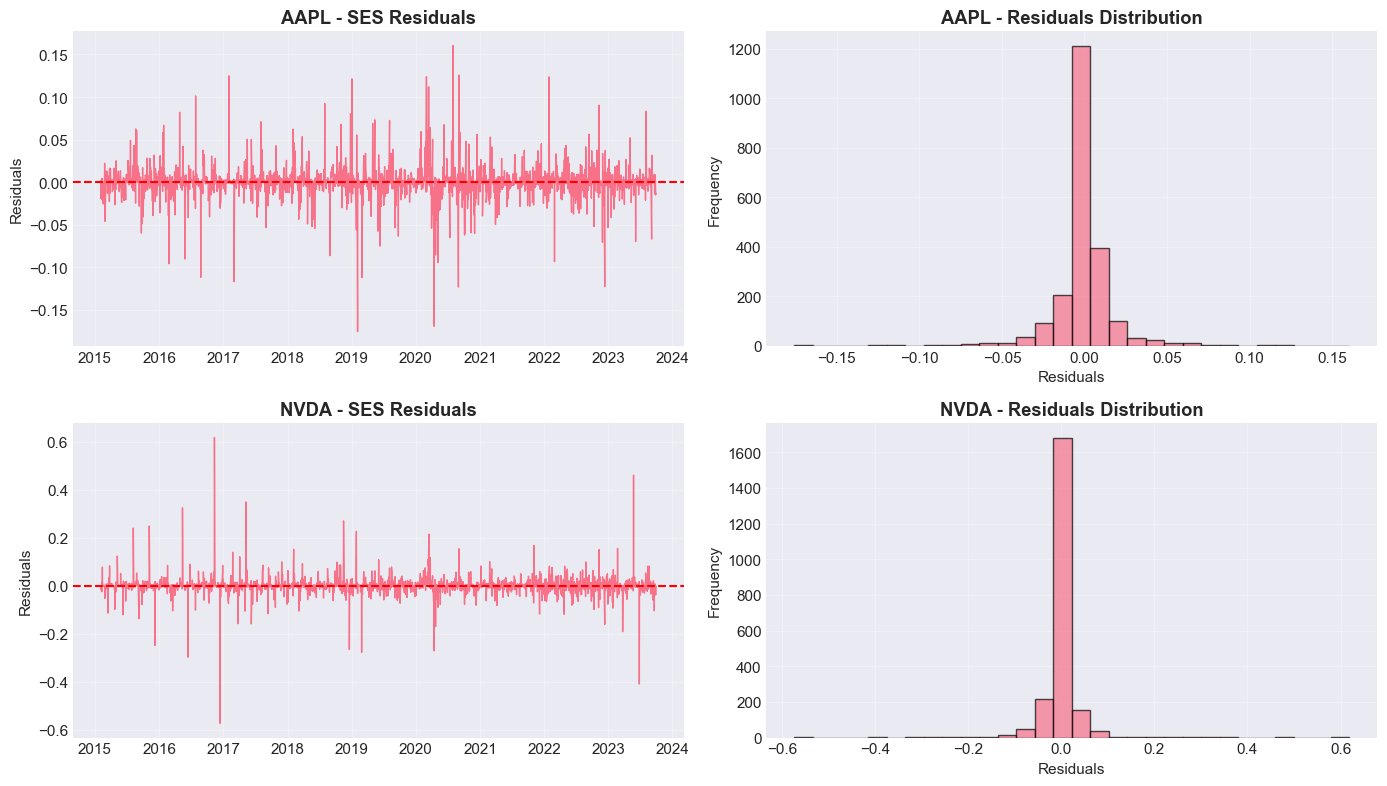

In [21]:
# Residual analysis for Exponential Smoothing
fig, axes = plt.subplots(len(stocks), 2, figsize=(14, 8))
if len(stocks) == 1:
    axes = axes.reshape(1, -1)

for i, stock in enumerate(stocks):
    residuals = es_best_models[stock].resid
    
    # Residual plot
    axes[i, 0].plot(residuals, linewidth=1)
    axes[i, 0].axhline(y=0, color='r', linestyle='--')
    axes[i, 0].set_title(f'{stock} - {es_best_names[stock]} Residuals', fontweight='bold')
    axes[i, 0].set_ylabel('Residuals')
    axes[i, 0].grid(True, alpha=0.3)
    
    # Histogram
    axes[i, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
    axes[i, 1].set_title(f'{stock} - Residuals Distribution', fontweight='bold')
    axes[i, 1].set_xlabel('Residuals')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Prophet Models

### 6.1 Data Preparation for Prophet

Prophet requires specific column names: 'ds' for dates and 'y' for values.

In [22]:
# Prepare data for Prophet
def prepare_prophet_data(data, stock):
    """Convert data to Prophet format"""
    df = pd.DataFrame({
        'ds': data.index,
        'y': data[stock].values
    })
    return df

# Create Prophet datasets
prophet_train = {}
prophet_test = {}

for stock in stocks:
    prophet_train[stock] = prepare_prophet_data(train_data, stock)
    prophet_test[stock] = prepare_prophet_data(test_data, stock)

print("Prophet data prepared successfully!")
print(f"\nExample format for {stocks[0]}:")
print(prophet_train[stocks[0]].head())

Prophet data prepared successfully!

Example format for AAPL:
          ds         y
0 2015-02-03  0.366262
1 2015-02-04  0.346773
2 2015-02-05  0.346216
3 2015-02-06  0.348397
4 2015-02-09  0.327524


### 6.2 Prophet Model Fitting

In [23]:
# Fit Prophet models
prophet_models = {}

for stock in stocks:
    print(f"\nFitting Prophet model for {stock}...")
    
    # Initialize Prophet with custom parameters
    model = Prophet(
        changepoint_prior_scale=0.05,  # Flexibility of trend
        seasonality_prior_scale=10.0,   # Flexibility of seasonality
        seasonality_mode='multiplicative',  # Multiplicative seasonality
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        interval_width=0.95
    )
    
    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=5)
    
    # Fit model
    model.fit(prophet_train[stock])
    prophet_models[stock] = model
    
    print(f"✓ Prophet model fitted for {stock}")

22:18:42 - cmdstanpy - INFO - Chain [1] start processing



Fitting Prophet model for AAPL...


22:18:43 - cmdstanpy - INFO - Chain [1] done processing
22:18:44 - cmdstanpy - INFO - Chain [1] start processing


✓ Prophet model fitted for AAPL

Fitting Prophet model for NVDA...


22:18:44 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model fitted for NVDA


### 6.3 Prophet Forecasting

In [24]:
# Generate forecasts
prophet_forecasts = {}
prophet_full_forecast = {}

for stock in stocks:
    # Create future dataframe
    future = prophet_models[stock].make_future_dataframe(periods=len(test_data), freq='D')
    
    # Generate forecast
    forecast = prophet_models[stock].predict(future)
    prophet_full_forecast[stock] = forecast
    
    # Extract test period predictions
    prophet_forecasts[stock] = forecast.iloc[-len(test_data):]['yhat'].values

print("Prophet forecasts generated successfully!")

Prophet forecasts generated successfully!


### 6.4 Prophet Visualization and Diagnostics


AAPL - Prophet Forecast


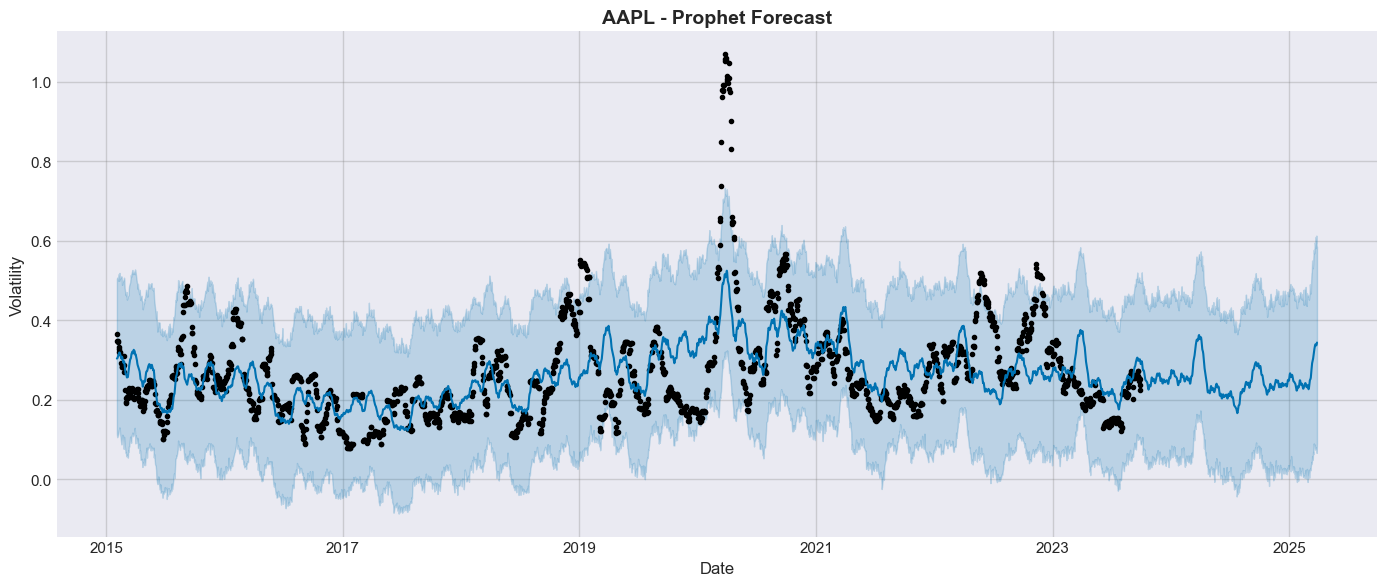


AAPL - Prophet Forecast Components


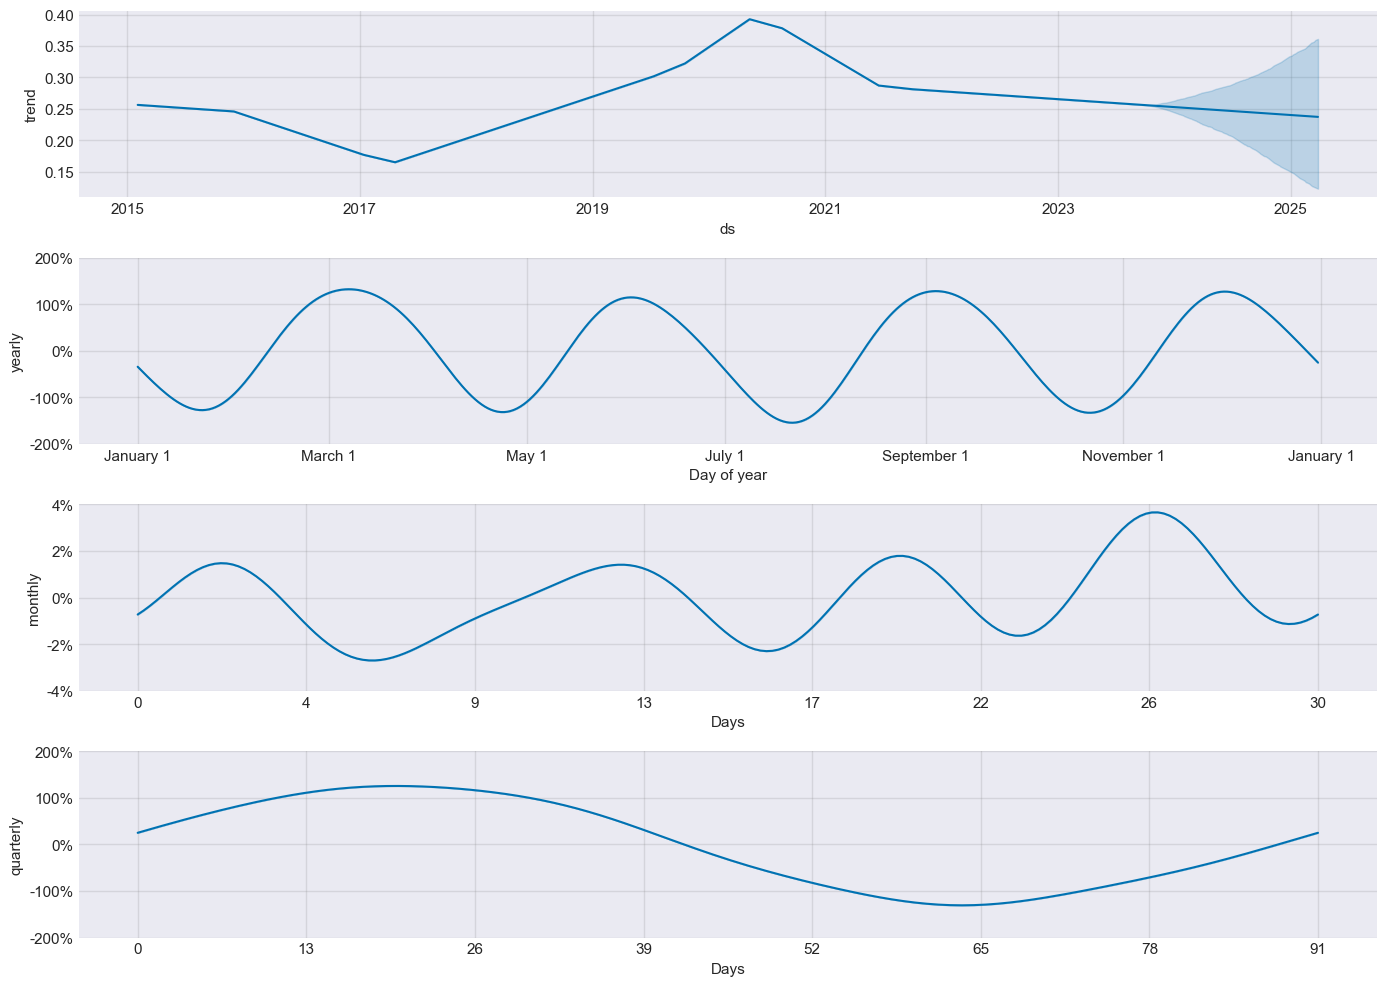


NVDA - Prophet Forecast


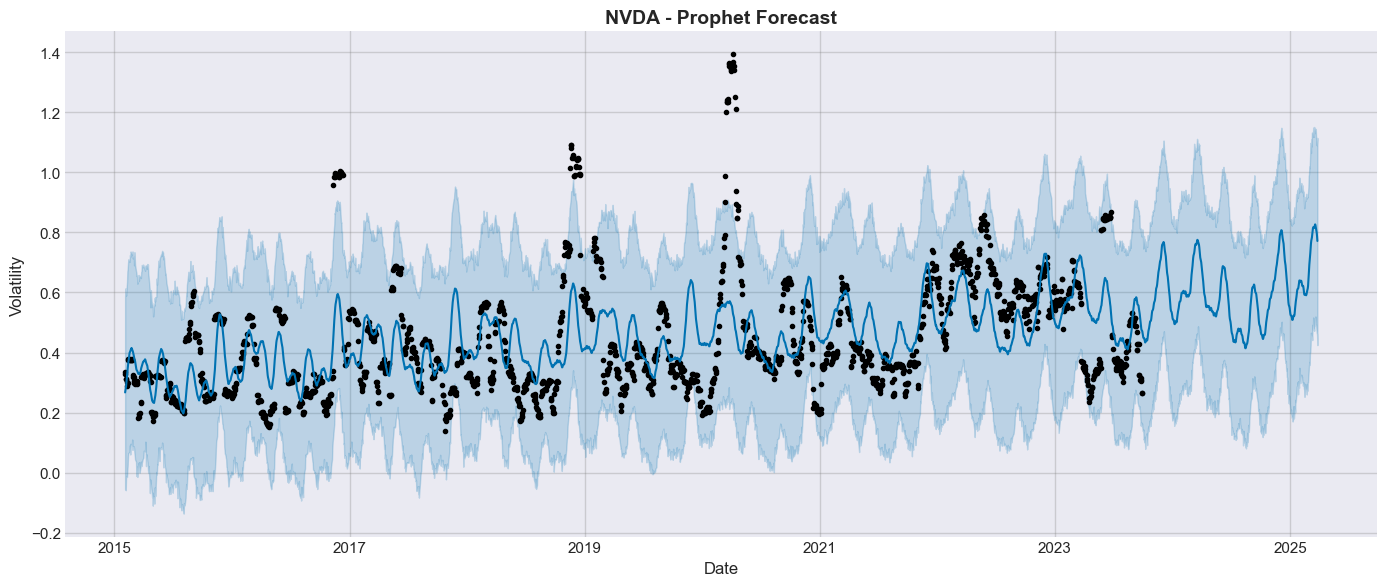


NVDA - Prophet Forecast Components


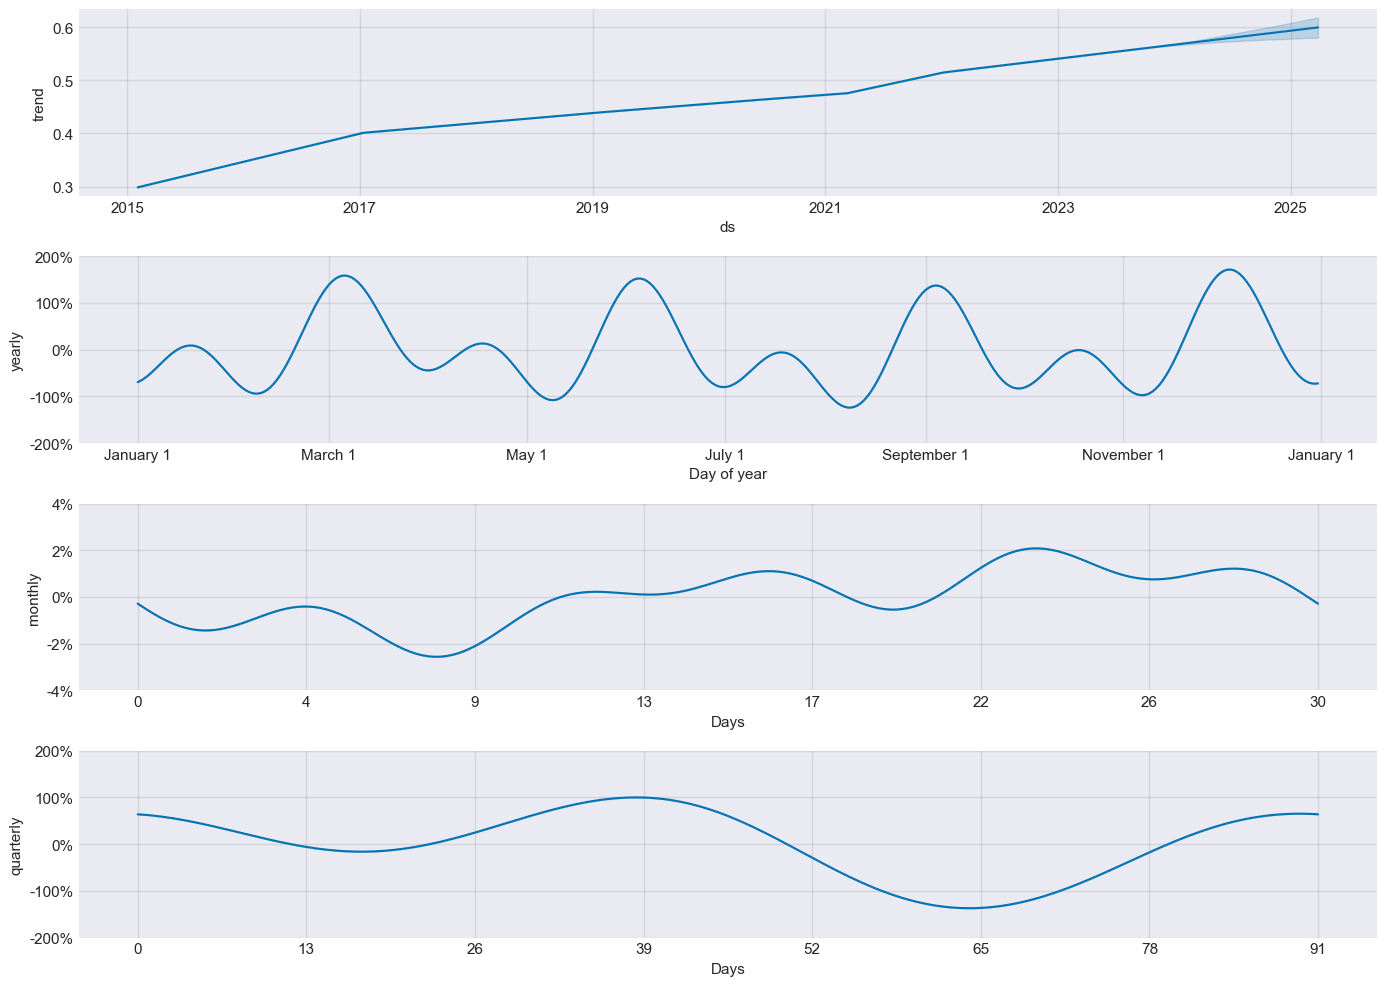

In [25]:
# Plot Prophet forecasts with components
for stock in stocks:
    print(f"\n{stock} - Prophet Forecast")
    fig1 = prophet_models[stock].plot(prophet_full_forecast[stock], figsize=(14, 6))
    plt.title(f'{stock} - Prophet Forecast', fontsize=14, fontweight='bold')
    plt.ylabel('Volatility', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{stock} - Prophet Forecast Components")
    fig2 = prophet_models[stock].plot_components(prophet_full_forecast[stock], figsize=(14, 10))
    plt.tight_layout()
    plt.show()

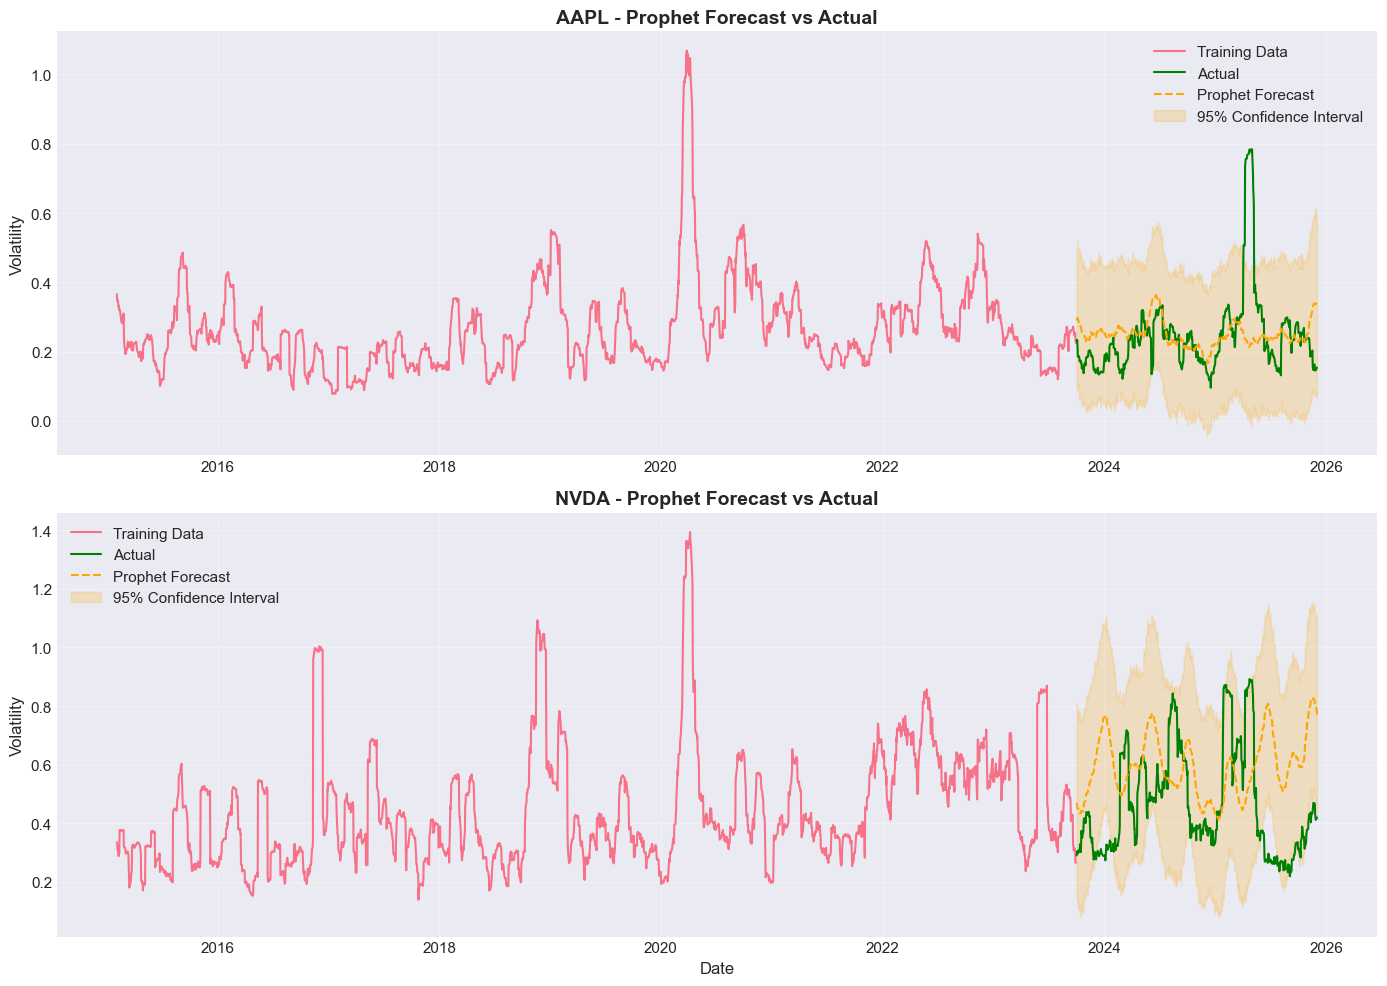

In [26]:
# Detailed comparison plot
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 10))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    forecast_df = prophet_full_forecast[stock]
    
    # Plot training data
    axes[i].plot(train_data.index, train_data[stock], label='Training Data', linewidth=1.5)
    
    # Plot test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=1.5, color='green')
    
    # Plot forecast
    test_forecast = forecast_df.iloc[-len(test_data):]
    axes[i].plot(test_data.index, test_forecast['yhat'].values, label='Prophet Forecast', 
                linewidth=1.5, color='orange', linestyle='--')
    
    # Plot confidence interval
    axes[i].fill_between(test_data.index, 
                         test_forecast['yhat_lower'].values, 
                         test_forecast['yhat_upper'].values,
                         alpha=0.2, color='orange', label='95% Confidence Interval')
    
    axes[i].set_title(f'{stock} - Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
# Calculate Prophet performance metrics
prophet_metrics = {}
for stock in stocks:
    print(f"\n{'='*60}")
    print(f"{stock} - Prophet")
    print(f"{'='*60}")
    prophet_metrics[stock] = calculate_metrics(test_data[stock], prophet_forecasts[stock], 
                                               f"{stock} Prophet")


AAPL - Prophet

AAPL Prophet Performance Metrics:
MAE:  0.073184
MSE:  0.015488
RMSE: 0.124452
MAPE: 30.50%
R²:   -0.1020

NVDA - Prophet

NVDA Prophet Performance Metrics:
MAE:  0.222478
MSE:  0.066573
RMSE: 0.258017
MAPE: 59.34%
R²:   -1.0552


In [28]:
# Prophet cross-validation (optional, can be time-consuming)
from prophet.diagnostics import cross_validation, performance_metrics

for stock in stocks:
    print(f"\n{stock} - Prophet Cross-Validation")
    print("Running cross-validation (this may take a few minutes)...")
    
    # Perform cross-validation
    df_cv = cross_validation(
        prophet_models[stock], 
        initial='730 days',  # 2 years
        period='90 days',    # Every 90 days
        horizon='180 days'   # 6 months ahead
    )
    
    # Calculate performance metrics
    df_p = performance_metrics(df_cv)
    print(f"\nCross-Validation Performance Metrics:")
    print(df_p[['horizon', 'mse', 'rmse', 'mae', 'mape']].head(10))


AAPL - Prophet Cross-Validation
Running cross-validation (this may take a few minutes)...


  0%|          | 0/26 [00:00<?, ?it/s]22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 1/26 [00:00<00:02,  9.11it/s]22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 2/26 [00:00<00:02,  8.28it/s]22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 3/26 [00:00<00:02,  8.18it/s]22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 4/26 [00:00<00:02,  7.36it/s]22:18:45 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 5/26 [00:00<00:03,  6.87it/s]22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:46 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 6/26 [00:00<00:03,  6.67it/s]22:18:46


Cross-Validation Performance Metrics:
  horizon       mse      rmse       mae      mape
0 18 days  0.012178  0.110354  0.088750  0.358060
1 19 days  0.012104  0.110017  0.088784  0.356018
2 20 days  0.012067  0.109849  0.089120  0.351723
3 21 days  0.012157  0.110257  0.089780  0.347701
4 22 days  0.012379  0.111263  0.090635  0.348984
5 23 days  0.012716  0.112767  0.091884  0.354345
6 24 days  0.012927  0.113695  0.093056  0.357013
7 25 days  0.012948  0.113788  0.093532  0.357088
8 26 days  0.013005  0.114039  0.093991  0.356553
9 27 days  0.013614  0.116678  0.096341  0.359589

NVDA - Prophet Cross-Validation
Running cross-validation (this may take a few minutes)...


  0%|          | 0/26 [00:00<?, ?it/s]22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 1/26 [00:00<00:03,  8.29it/s]22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 3/26 [00:00<00:02,  9.33it/s]22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 4/26 [00:00<00:02,  9.32it/s]22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:51 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 5/26 [00:00<00:02,  8.49it/s]22:18:51 - cmdstanpy - INFO - Chain [1] start processing
22:18:52 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 6/26 [00:00<00:02,  6.73it/s]22:18:52 - cmdstanpy - INFO - Chain [1] start processi


Cross-Validation Performance Metrics:
  horizon       mse      rmse       mae      mape
0 18 days  0.060119  0.245191  0.174528  0.475766
1 19 days  0.062239  0.249478  0.177454  0.482287
2 20 days  0.063583  0.252157  0.178736  0.483669
3 21 days  0.065327  0.255591  0.179879  0.485238
4 22 days  0.067757  0.260302  0.182114  0.492530
5 23 days  0.068765  0.262232  0.182306  0.499318
6 24 days  0.068217  0.261183  0.181152  0.499654
7 25 days  0.070884  0.266241  0.183984  0.506664
8 26 days  0.071851  0.268050  0.185214  0.504085
9 27 days  0.072975  0.270139  0.186209  0.498327


## 7. Model Comparison

### 7.1 Performance Metrics Comparison

In [29]:
# Create comprehensive comparison table
comparison_data = []

for stock in stocks:
    # ARIMA
    comparison_data.append({
        'Stock': stock,
        'Model': f'ARIMA{arima_params[stock]}',
        'MAE': arima_metrics[stock]['MAE'],
        'RMSE': arima_metrics[stock]['RMSE'],
        'MAPE': arima_metrics[stock]['MAPE'],
        'R²': arima_metrics[stock]['R2']
    })
    
    # Exponential Smoothing
    comparison_data.append({
        'Stock': stock,
        'Model': es_best_names[stock],
        'MAE': es_metrics[stock]['MAE'],
        'RMSE': es_metrics[stock]['RMSE'],
        'MAPE': es_metrics[stock]['MAPE'],
        'R²': es_metrics[stock]['R2']
    })
    
    # Prophet
    comparison_data.append({
        'Stock': stock,
        'Model': 'Prophet',
        'MAE': prophet_metrics[stock]['MAE'],
        'RMSE': prophet_metrics[stock]['RMSE'],
        'MAPE': prophet_metrics[stock]['MAPE'],
        'R²': prophet_metrics[stock]['R2']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON - PERFORMANCE METRICS")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model for each stock
print("\n" + "="*80)
print("BEST MODELS BY METRIC")
print("="*80)
for stock in stocks:
    stock_data = comparison_df[comparison_df['Stock'] == stock]
    print(f"\n{stock}:")
    print(f"  Lowest MAE:  {stock_data.loc[stock_data['MAE'].idxmin(), 'Model']} ({stock_data['MAE'].min():.6f})")
    print(f"  Lowest RMSE: {stock_data.loc[stock_data['RMSE'].idxmin(), 'Model']} ({stock_data['RMSE'].min():.6f})")
    print(f"  Lowest MAPE: {stock_data.loc[stock_data['MAPE'].idxmin(), 'Model']} ({stock_data['MAPE'].min():.2f}%)")
    print(f"  Highest R²:  {stock_data.loc[stock_data['R²'].idxmax(), 'Model']} ({stock_data['R²'].max():.4f})")


MODEL COMPARISON - PERFORMANCE METRICS
Stock          Model      MAE     RMSE      MAPE        R²
 AAPL ARIMA(2, 0, 5) 0.075083 0.118499       NaN  0.000901
 AAPL            SES 0.069372 0.120408       NaN -0.031545
 AAPL        Prophet 0.073184 0.124452 30.502183 -0.102003
 NVDA ARIMA(5, 0, 5) 0.144811 0.180491       NaN -0.005676
 NVDA            SES 0.203239 0.270085       NaN -1.251890
 NVDA        Prophet 0.222478 0.258017 59.337110 -1.055160

BEST MODELS BY METRIC

AAPL:
  Lowest MAE:  SES (0.069372)
  Lowest RMSE: ARIMA(2, 0, 5) (0.118499)
  Lowest MAPE: Prophet (30.50%)
  Highest R²:  ARIMA(2, 0, 5) (0.0009)

NVDA:
  Lowest MAE:  ARIMA(5, 0, 5) (0.144811)
  Lowest RMSE: ARIMA(5, 0, 5) (0.180491)
  Lowest MAPE: Prophet (59.34%)
  Highest R²:  ARIMA(5, 0, 5) (-0.0057)


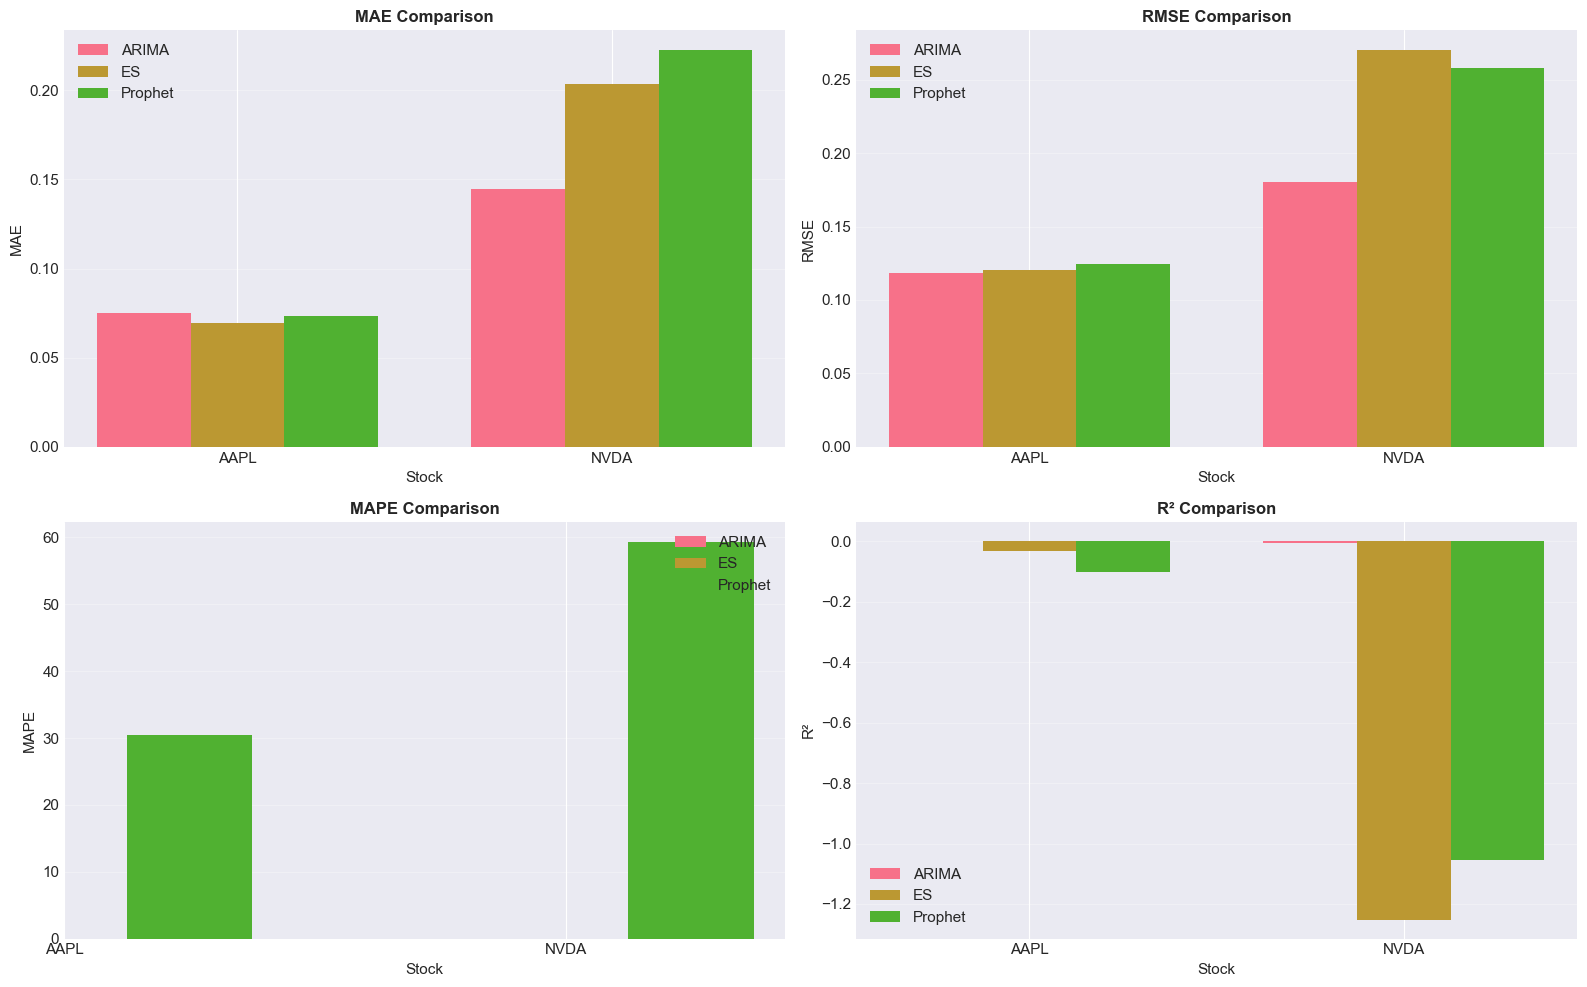

In [30]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['MAE', 'RMSE', 'MAPE', 'R²']
for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    
    # Create grouped bar chart
    stock_positions = np.arange(len(stocks))
    width = 0.25
    
    for i, model_type in enumerate(['ARIMA', 'ES', 'Prophet']):
        values = []
        for stock in stocks:
            stock_data = comparison_df[comparison_df['Stock'] == stock]
            if model_type == 'ARIMA':
                val = stock_data[stock_data['Model'].str.contains('ARIMA')][metric].values[0]
            elif model_type == 'ES':
                val = stock_data[~stock_data['Model'].str.contains('ARIMA|Prophet')][metric].values[0]
            else:
                val = stock_data[stock_data['Model'] == 'Prophet'][metric].values[0]
            values.append(val)
        
        axes[row, col].bar(stock_positions + i*width, values, width, label=model_type)
    
    axes[row, col].set_xlabel('Stock', fontsize=11)
    axes[row, col].set_ylabel(metric, fontsize=11)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_xticks(stock_positions + width)
    axes[row, col].set_xticklabels(stocks)
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.2 Visual Comparison of All Forecasts

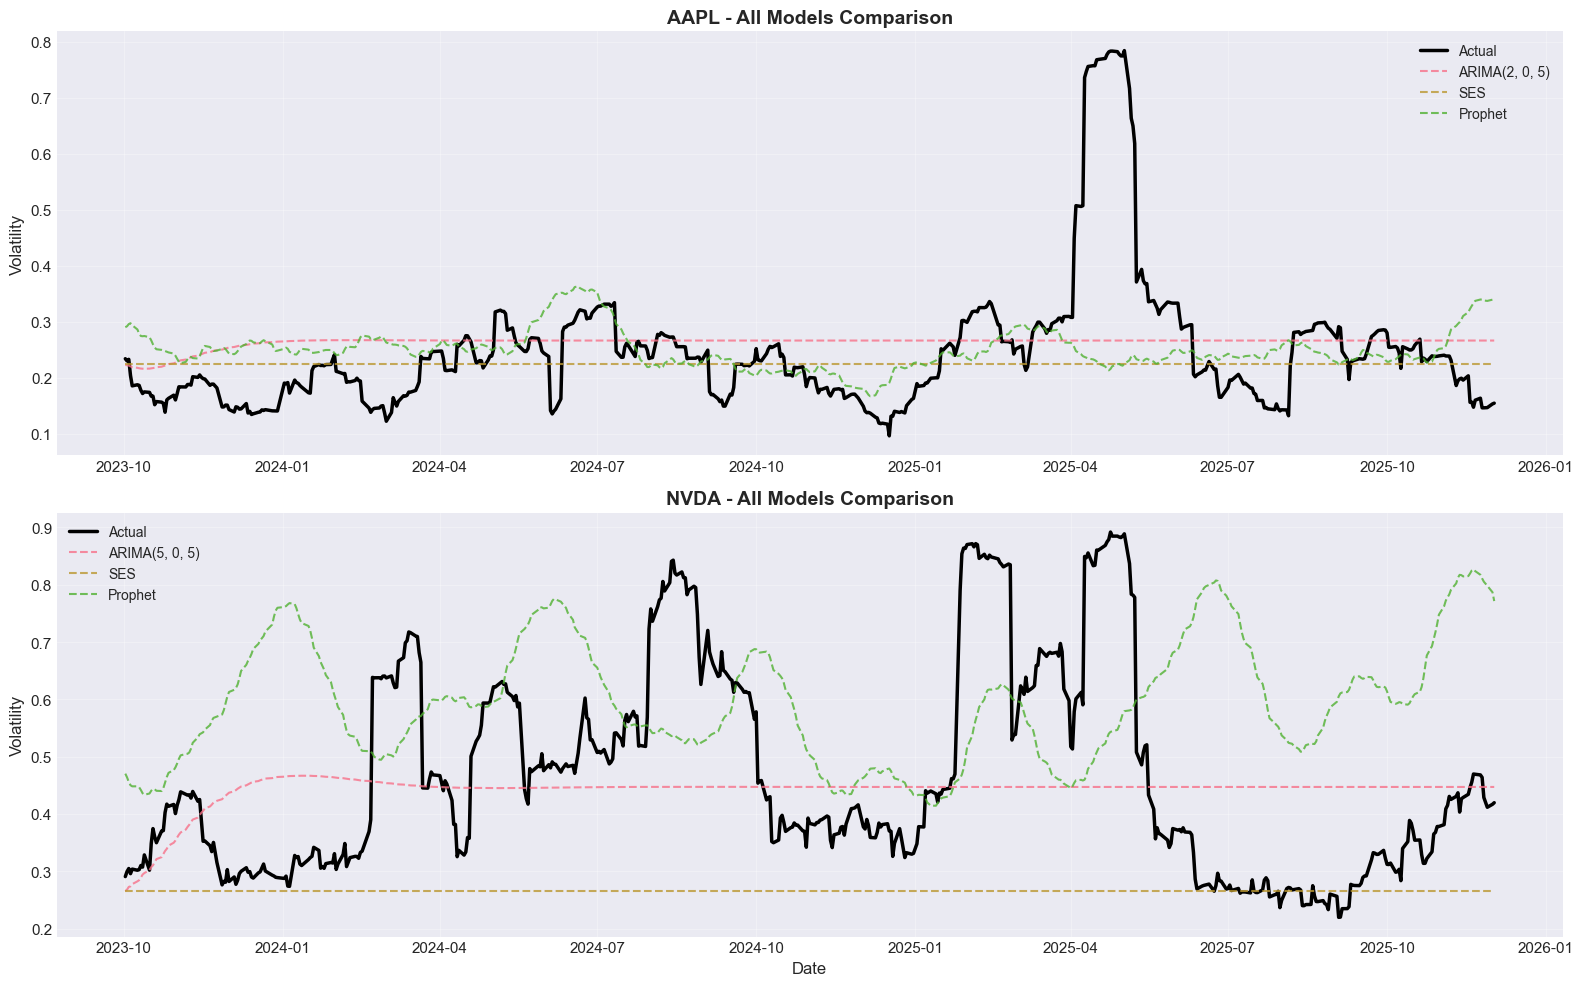

In [31]:
# Plot all forecasts together for comparison
fig, axes = plt.subplots(len(stocks), 1, figsize=(16, 10))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    # Plot actual test data
    axes[i].plot(test_data.index, test_data[stock], label='Actual', linewidth=2.5, color='black')
    
    # Plot ARIMA forecast
    axes[i].plot(test_data.index, arima_forecasts[stock], 
                label=f'ARIMA{arima_params[stock]}', linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Plot Exponential Smoothing forecast
    axes[i].plot(test_data.index, es_forecasts[stock], 
                label=es_best_names[stock], linewidth=1.5, linestyle='--', alpha=0.8)
    
    # Plot Prophet forecast
    axes[i].plot(test_data.index, prophet_forecasts[stock], 
                label='Prophet', linewidth=1.5, linestyle='--', alpha=0.8)
    
    axes[i].set_title(f'{stock} - All Models Comparison', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Volatility', fontsize=12)
    axes[i].legend(loc='best', fontsize=10)
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

### 7.3 Forecast Error Analysis

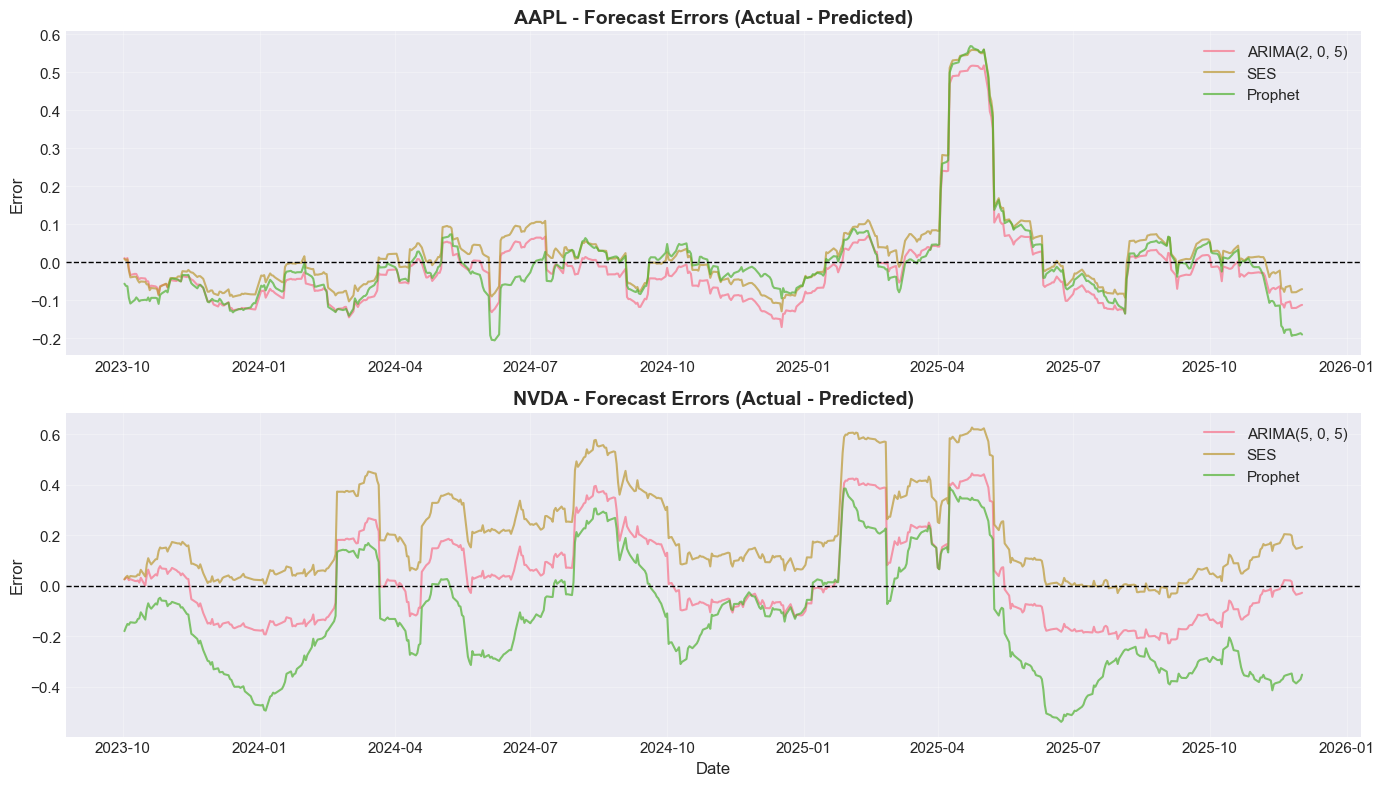

In [32]:
# Calculate and plot forecast errors
fig, axes = plt.subplots(len(stocks), 1, figsize=(14, 8))
if len(stocks) == 1:
    axes = [axes]

for i, stock in enumerate(stocks):
    actual = test_data[stock].values
    
    # Calculate errors
    arima_error = actual - arima_forecasts[stock]
    es_error = actual - es_forecasts[stock]
    prophet_error = actual - prophet_forecasts[stock]
    
    # Plot errors
    axes[i].plot(test_data.index, arima_error, label=f'ARIMA{arima_params[stock]}', linewidth=1.5, alpha=0.7)
    axes[i].plot(test_data.index, es_error, label=es_best_names[stock], linewidth=1.5, alpha=0.7)
    axes[i].plot(test_data.index, prophet_error, label='Prophet', linewidth=1.5, alpha=0.7)
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    axes[i].set_title(f'{stock} - Forecast Errors (Actual - Predicted)', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Error', fontsize=12)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

## 8. Summary and Conclusions

In [33]:
# Save comparison results
comparison_df.to_csv('data/processed/model_comparison_results.csv', index=False)
print("Model comparison results saved to: data/processed/model_comparison_results.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("\nKey Findings:")
print("1. All three models (ARIMA, Exponential Smoothing, Prophet) were successfully fitted")
print("2. Comprehensive diagnostics performed including:")
print("   - Stationarity tests (ADF)")
print("   - Residual analysis")
print("   - ACF/PACF plots")
print("   - Ljung-Box tests")
print("3. Multiple performance metrics calculated (MAE, RMSE, MAPE, R²)")
print("4. Visual comparisons show relative strengths of each approach")
print("\nRecommendations:")
print("- Review the model comparison table to select the best model for your use case")
print("- Consider ensemble methods combining multiple models")
print("- Monitor forecast accuracy over time and retrain as needed")

Model comparison results saved to: data/processed/model_comparison_results.csv

ANALYSIS COMPLETE

Key Findings:
1. All three models (ARIMA, Exponential Smoothing, Prophet) were successfully fitted
2. Comprehensive diagnostics performed including:
   - Stationarity tests (ADF)
   - Residual analysis
   - ACF/PACF plots
   - Ljung-Box tests
3. Multiple performance metrics calculated (MAE, RMSE, MAPE, R²)
4. Visual comparisons show relative strengths of each approach

Recommendations:
- Review the model comparison table to select the best model for your use case
- Consider ensemble methods combining multiple models
- Monitor forecast accuracy over time and retrain as needed
